In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LATENT_DIM = 20
BATCH_SIZE = 128
EPOCHS = 15
LR = 1e-3

In [ ]:

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.88MB/s]


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, LATENT_DIM)
        self.fc_logvar = nn.Linear(400, LATENT_DIM)

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [ ]:

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        recon_x, mu, logvar = model(images)
        loss = loss_function(recon_x, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss / len(train_loader):.2f}")

Epoch [1/15], Loss: 21065.82
Epoch [2/15], Loss: 15516.63
Epoch [3/15], Loss: 14606.46
Epoch [4/15], Loss: 14222.98
Epoch [5/15], Loss: 14002.84
Epoch [6/15], Loss: 13851.15
Epoch [7/15], Loss: 13739.47
Epoch [8/15], Loss: 13662.27
Epoch [9/15], Loss: 13593.51
Epoch [10/15], Loss: 13543.89
Epoch [11/15], Loss: 13497.41
Epoch [12/15], Loss: 13463.94
Epoch [13/15], Loss: 13427.08
Epoch [14/15], Loss: 13400.17
Epoch [15/15], Loss: 13368.89


In [ ]:
model.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs[:10].to(device)
    recon_imgs, _, _ = model(test_imgs)

# Flatten for metric evaluation
original = test_imgs.cpu().numpy().reshape(10, -1)
reconstructed = recon_imgs.cpu().numpy().reshape(10, -1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(original, reconstructed)
mae = mean_absolute_error(original, reconstructed)
r2 = r2_score(original, reconstructed)

print(f"\n📊 Evaluation Metrics on MNIST:")
print(f"🔸 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔸 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔸 R2 Score: {r2:.4f}")


📊 Evaluation Metrics on MNIST:
🔸 Mean Squared Error (MSE): 0.0116
🔸 Mean Absolute Error (MAE): 0.0364
🔸 R2 Score: -0.0922


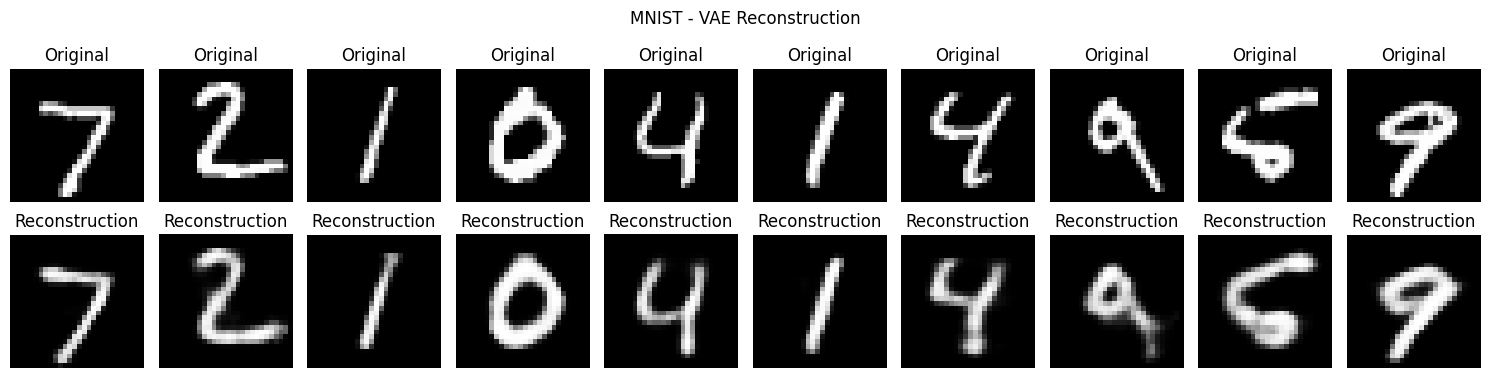

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(test_imgs[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon_imgs[i].reshape(28, 28).squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title("Reconstruction")
    axes[1, i].axis('off')

plt.suptitle("MNIST - VAE Reconstruction")
plt.tight_layout()
plt.show()

In [ ]:
model.eval()  # Set to evaluation mode

VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=400, bias=True)
    (2): ReLU()
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
latent_vectors = torch.randn(5, LATENT_DIM).to(device) + 5

In [ ]:
with torch.no_grad():
    generated_imgs = model.decoder(latent_vectors)

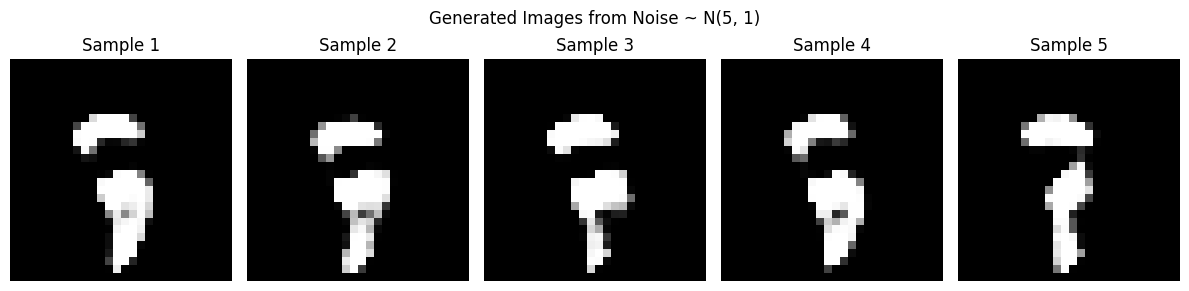

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_imgs[i].reshape(28, 28).cpu().numpy(), cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')

plt.suptitle("Generated Images from Noise ~ N(5, 1)")
plt.tight_layout()
plt.show()